# 001. Naive Rag with LangGraph

This is a baseline RAG Architecture to compare with other more advanced RAG arcitectures followings.

## Congifuration

In [40]:
from dotenv import load_dotenv
from tools import logging

import os

In [41]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [42]:
from dotenv import load_dotenv
import os
load_dotenv(override=True)

True

In [43]:
from tools import logging
logging.langsmith("naive-RAG")

LangSmith is tracing....
[Project Name]
naive-RAG


## PDF Retrieval Chain

In [44]:
from tools.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/Deepseek-r1.pdf"]).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

# 1. State Definition

In [45]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    question: Annotated[str, "Question"] 
    context: Annotated[str, "Context"] 
    answer: Annotated[str, "Answer"]  
    messages: Annotated[list, add_messages] 

# 2. Node Definition

In [46]:
from langchain_teddynote.messages import messages_to_history
from tools.utils import format_docs


# 1. Retrieve Node
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs)

    return {"context": retrieved_docs}


# 2. Answer Node
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"]
    context = state["context"]
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

# 3. Edges

In [47]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

workflow.add_edge("retrieve", "llm_answer") 
workflow.add_edge("llm_answer", END)  

workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# 4. Graph Visualization

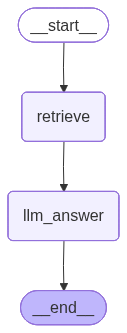

In [48]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


# 5. Graph Execution

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="What is DeepSeek-R1-Zero?")
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>solvingcomplexproblems,resultinginthedevelopmentofDeepSeek-R1-Zero. DeepSeek-
R1-Zero demonstrates capabilities such as self-verification, reflection, and generating
longCoTs,markingasignificantmilestonefortheresearchcommunity. Notably,itisthe</content><source>data/Deepseek-r1.pdf</source><page>4</page></document>
<document><content>spontaneousdevelopmentsignificantlyenhancesDeepSeek-R1-Zero’sreasoningcapabilities,
enablingittotacklemorechallengingtaskswithgreaterefficiencyandaccuracy.
AhaMomentofDeepSeek-R1-Zero Aparticularlyintriguingphenomenonobservedduring</content><source>data/Deepseek-r1.pdf</source><page>8</page></document>
<document><content>DeepSeek-R1-Zerotoattainrobustreasoningcapabilitieswithouttheneedforanysupervised
fine-tuning data. This is a noteworthy achievement, as it underscores the model’s ability to
learnandgeneralizeeffectivelythroughRLalone. Additionally,theperform

In [53]:
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
DeepSeek-R1-Zero is a model that applies reinforcement learning (RL) directly to the base model without any supervised fine-tuning (SFT) data. It demonstrates capabilities such as self-verification, reflection, and generating long chains of thought (CoTs), achieving robust reasoning capabilities and competitive performance across various tasks. It can learn and generalize effectively through RL alone.

**Source**
- data/Deepseek-r1.pdf (page 4)
- data/Deepseek-r1.pdf (page 7)
- data/Deepseek-r1.pdf (page 5)

In [55]:
outputs = app.get_state(config).values
outputs

{'question': 'What is DeepSeek-R1-Zero?',
 'context': '<document><content>solvingcomplexproblems,resultinginthedevelopmentofDeepSeek-R1-Zero. DeepSeek-\nR1-Zero demonstrates capabilities such as self-verification, reflection, and generating\nlongCoTs,markingasignificantmilestonefortheresearchcommunity. Notably,itisthe</content><source>data/Deepseek-r1.pdf</source><page>4</page></document>\n<document><content>spontaneousdevelopmentsignificantlyenhancesDeepSeek-R1-Zero’sreasoningcapabilities,\nenablingittotacklemorechallengingtaskswithgreaterefficiencyandaccuracy.\nAhaMomentofDeepSeek-R1-Zero Aparticularlyintriguingphenomenonobservedduring</content><source>data/Deepseek-r1.pdf</source><page>8</page></document>\n<document><content>DeepSeek-R1-Zerotoattainrobustreasoningcapabilitieswithouttheneedforanysupervised\nfine-tuning data. This is a noteworthy achievement, as it underscores the model’s ability to\nlearnandgeneralizeeffectivelythroughRLalone. Additionally,theperformanceofDeepSeek-</